In [99]:
from datasets import Dataset, load_from_disk
from dataclasses import dataclass, field
import warnings
from typing import Optional
import os
import json

import torch
import numpy as np

@dataclass(frozen=True)
class SplitResults():
    # this could just be a dataset but I want type safety about the columns
    n: int
    ids: np.ndarray  # (n,)
    weak_soft_labels: np.ndarray  # (n,)
    gt_soft_labels: np.ndarray  # (n,)
    gt_hard_labels: np.ndarray  # (n,)
    logodds: np.ndarray  # (n,)
    pre_hiddens: Optional[np.ndarray] = None # (n, n_layers, d)
    post_hiddens: Optional[np.ndarray] = None # (n, n_layers, d)

    def __post_init__(self):
        assert len(self.ids) == self.n
        assert len(self.weak_soft_labels) == self.n
        assert len(self.gt_soft_labels) == self.n
        assert len(self.gt_hard_labels) == self.n
        assert self.logodds.shape == (self.n,)
        assert self.pre_hiddens is None or self.pre_hiddens.shape[0] == self.n
        assert self.post_hiddens is None or  self.post_hiddens.shape[0] == self.n

    def truncate_to(self, n: int):
        new_pre_hiddens = self.pre_hiddens[:n] if self.pre_hiddens is not None else None
        new_post_hiddens = self.post_hiddens[:n] if self.post_hiddens is not None else None
        return SplitResults(
            n=n,
            ids=self.ids[:n],
            weak_soft_labels=self.weak_soft_labels[:n],
            gt_soft_labels=self.gt_soft_labels[:n],
            gt_hard_labels=self.gt_hard_labels[:n],
            logodds=self.logodds[:n],
            pre_hiddens=new_pre_hiddens,
            post_hiddens=new_post_hiddens,
        )


@dataclass
class TrainResults():
    n_steps: int
    ids: np.ndarray  # (n,)
    steps: np.ndarray  # (n,)
    weak_soft_labels: np.ndarray  # (n,)
    gt_soft_labels: np.ndarray # (n,)
    pred_logodds: np.ndarray # (n,)
    midtrain_hiddens: np.ndarray # (n, n_layers, d)
    texts: np.ndarray # (n,)
    weak_error: np.ndarray = field(init=False)  # (n,)  # weak_soft_labels - gt_soft_labels
    
    @property
    def n(self):
        return len(self.ids)

    def __post_init__(self):
        self.weak_error = self.weak_soft_labels - self.gt_soft_labels
        assert self.ids.shape == (self.n,)
        assert self.steps.shape == (self.n,)
        assert self.weak_soft_labels.shape == (self.n,)
        assert self.gt_soft_labels.shape == (self.n,)
        assert self.weak_error.shape == (self.n,)
        assert self.texts.shape == (self.n,)
        assert self.pred_logodds.shape == (self.n,)
        assert self.midtrain_hiddens.shape[0] == self.n

    def truncate_test_to(self, n: int):
        return TrainResults(
            n_steps=self.n_steps,
            ids=self.ids,
            steps=self.steps,
            weak_soft_labels=self.weak_soft_labels,
            gt_soft_labels=self.gt_soft_labels,
            pred_logodds=self.pred_logodds,
            midtrain_hiddens=self.midtrain_hiddens,
            texts=self.texts,
        )


@dataclass
class RunResult():
    weak_acc: float
    strong_acc: float
    w2s_acc: float
    pgr: float
    run: TrainResults  # with n=n_train_steps
    w2s_train: SplitResults  
    w2s_vals: dict[int, SplitResults]  # step -> SplitResults
    w2s_test: SplitResults
    weak_test: SplitResults
    strong_test: SplitResults
    cfg: dict = field(repr=False)

    def __post_init__(self):
        if not (self.w2s_test.n == self.weak_test.n == self.strong_test.n):
            # sometimes these are different sizes when the runs used different batch sizes
            min_n = min(self.w2s_test.n, self.weak_test.n, self.strong_test.n)
            
            # truncate to the minimum length
            self.w2s_test = self.w2s_test.truncate_to(min_n)
            self.weak_test = self.weak_test.truncate_to(min_n)
            self.strong_test = self.strong_test.truncate_to(min_n)
    
        v0 = self.w2s_vals.get(0)
        if v0 is not None:
            assert all(np.all(v.ids == v0.ids) for v in self.w2s_vals.values())
            assert all(np.all(v.weak_soft_labels == v0.weak_soft_labels) for v in self.w2s_vals.values())
            assert all(np.all(v.gt_soft_labels == v0.gt_soft_labels) for v in self.w2s_vals.values())
            assert all(np.all(v.gt_hard_labels == v0.gt_hard_labels) for v in self.w2s_vals.values())

        if not np.all(self.w2s_test.ids == self.weak_test.ids):
            warnings.warn("IDs in w2s_test and weak_test do not match")
        if not np.all(self.w2s_test.ids == self.strong_test.ids):
            warnings.warn("IDs in w2s_test and strong_test do not match")
        if not np.all(self.w2s_test.gt_soft_labels == self.weak_test.gt_soft_labels):
            warnings.warn("GT soft labels in w2s_test and weak_test do not match")
        if not np.all(self.w2s_test.gt_soft_labels == self.strong_test.gt_soft_labels):
            warnings.warn("GT soft labels in w2s_test and strong_test do not match")
        if not np.all(self.w2s_test.gt_hard_labels == self.weak_test.gt_hard_labels):
            warnings.warn("GT hard labels in w2s_test and weak_test do not match")
        if not np.all(self.w2s_test.gt_hard_labels == self.strong_test.gt_hard_labels):
            warnings.warn("GT hard labels in w2s_test and strong_test do not match")


    def select(self, min_step: int = 0, max_step: int = -1) -> "RunResult":
        """
        Returns a new RunResult with only the data from the specified steps,
        min is inclusive, max is exclusive
        """
        if max_step == -1:
            max_step = self.run.n_steps
        assert min_step < max_step
        assert min_step >= 0
        assert max_step <= self.run.n_steps
        
        step_mask = (self.run.steps >= min_step) & (self.run.steps < max_step)
        return RunResult(
            weak_acc=self.weak_acc,
            strong_acc=self.strong_acc,
            w2s_acc=self.w2s_acc,
            pgr=self.pgr,
            run=TrainResults(
                n_steps=max_step - min_step,
                ids=self.run.ids[step_mask],
                steps=self.run.steps[step_mask],
                weak_soft_labels=self.run.weak_soft_labels[step_mask],
                gt_soft_labels=self.run.gt_soft_labels[step_mask],
                pred_logodds=self.run.pred_logodds[step_mask],
                midtrain_hiddens=self.run.midtrain_hiddens[step_mask],
                texts=self.run.texts[step_mask],
            ),
            w2s_train=self.w2s_train,
            w2s_vals={k: v for k, v in self.w2s_vals.items() if k >= min_step and k < max_step},
            w2s_test=self.w2s_test,
            weak_test=self.weak_test,
            strong_test=self.strong_test,
            cfg=self.cfg,
        )


def load_run_result(w2s_path: str, weak_path: str, strong_path: str) -> RunResult:

    ### Load config ###
    w2s_cfg = json.load(open(os.path.join(w2s_path, "config.json")))
        
    ### Gather validation results from throughout training ###
    val_results_paths = [p for p in os.listdir(w2s_path) if p.startswith("eval_results") and p[-1].isdigit()]
    
    w2s_val_results = dict()
    for path in val_results_paths:
        step = int(path.split("_")[-1])
        val_ds: Dataset = load_from_disk(os.path.join(w2s_path, path)).with_format("numpy")  # type: ignore

        # NOTE: for a short period, intermediate evals have a different perspective on label names
        if 'weak_soft_label' not in val_ds.column_names:
            warnings.warn("It appears these w2s val results were produced with a version of the code that called weak_soft_label \"soft_label\"")
            val_ds = val_ds.rename_columns(
                {
                    "soft_label": "weak_soft_label",
                    "hard_label": "weak_hard_label",
                }
            )
            
        w2s_val_results[step] = SplitResults(
            n=len(val_ds),
            ids=val_ds["id"],  # type: ignore
            weak_soft_labels=val_ds["weak_soft_label"][:, 1],  # type: ignore
            gt_soft_labels=val_ds["soft_label"][:, 1] if "soft_label" in val_ds.column_names else np.full(len(val_ds), np.inf),  # type: ignore
            gt_hard_labels=val_ds["hard_label"] if "hard_label" in val_ds.column_names else np.full(len(val_ds), np.inf),  # type: ignore
            logodds=val_ds["logit"][:, 1] - val_ds["logit"][:, 0],  # type: ignore
        )
    
    ### Load test results ###
    test_results = dict()
    for name, path in zip(["weak", "strong", "w2s"], [weak_path, strong_path, w2s_path]):
        test_ds: Dataset = load_from_disk(os.path.join(path, "eval_results_final")).with_format("numpy")  # type: ignore
        try:
            logodds = test_ds["logit"][:, 1] - test_ds["logit"][:, 0]  # type: ignore
        except KeyError:
            warnings.warn(f"Could not find logit columns in {path}, inferring from \"soft_pred\" instead")
            p = test_ds["soft_pred"][:, 1]  # type: ignore
            logodds = np.log(p / ((1 - p) + 1e-12) + 1e-12)
        try:
            weak_soft_labels = test_ds["weak_soft_label"][:, 1]  # type: ignore
        except KeyError:
            warnings.warn(f"Could not find weak_soft_label columns in {path}, inferring from \"soft_label\" instead")
            weak_soft_labels = np.full(len(test_ds), np.inf)  # type: ignore
        test_results[name] = SplitResults(
            n=len(test_ds),
            ids=test_ds["id"],  # type: ignore
            weak_soft_labels=weak_soft_labels,
            gt_soft_labels=test_ds["soft_label"][:, 1],  # type: ignore
            gt_hard_labels=test_ds["hard_label"],  # type: ignore
            logodds=logodds,
        )

    ### Load training results ###
    # note that in this case "soft_label" means weak_soft_label, and there is a "gt_soft_label" column
    train_ds: Dataset = load_from_disk(os.path.join(w2s_path, "train_ds")).with_format("numpy")  # type: ignore
    # NOTE: the training set is truncated to the nearest multiple of the batch size
    train_ds = train_ds.select(range(0, len(train_ds) - len(train_ds) % w2s_cfg["batch_size"]))  # type: ignore
    pretrain_hiddens = torch.load(os.path.join(w2s_path, "pre_train_hiddens.pt"), map_location="cpu").float().numpy()[:len(train_ds)]
    try:
        posttrain_hiddens = torch.load(os.path.join(w2s_path, "post_train_hiddens.pt"), map_location="cpu").float().numpy()[:len(train_ds)]
    except FileNotFoundError:
        posttrain_hiddens = None
    w2s_train_ds = SplitResults(
        n=len(train_ds),
        ids=train_ds["id"],  # type: ignore
        weak_soft_labels=train_ds["soft_label"][:, 1],  # type: ignore
        gt_soft_labels=train_ds["gt_soft_label"][:, 1],  # type: ignore
        gt_hard_labels=train_ds["gt_hard_label"],  # type: ignore
        logodds=np.full(len(train_ds), np.inf),  # train_ds doesn't contain predictions
        pre_hiddens=pretrain_hiddens,
        post_hiddens=posttrain_hiddens,
    )
    
    # grab train hiddens and logodds
    train_logodds_dict = torch.load(os.path.join(w2s_path, "train_logodds.pt"), map_location="cpu")
    train_logodds, lo_ids = train_logodds_dict["logodds"].float().numpy(), train_logodds_dict["ids"]
    n_train_seen = len(train_logodds)
    try:
        train_hiddens = torch.load(os.path.join(w2s_path, "train_hiddens.pt"), map_location="cpu").float().numpy()
    except FileNotFoundError:
        train_hiddens = np.full((n_train_seen, 1, 1), np.inf)

    # join the weak_soft_labels, texts, and gt_soft_labels from the training set
    n_epochs = n_train_seen // len(w2s_train_ds.ids)
    run_dict = {
        "ids": np.tile(w2s_train_ds.ids, n_epochs + 1)[:n_train_seen],
        "weak_soft_labels": np.tile(w2s_train_ds.weak_soft_labels, n_epochs + 1)[:n_train_seen],
        "gt_soft_labels": np.tile(w2s_train_ds.gt_soft_labels, n_epochs + 1)[:n_train_seen],
        "texts": np.tile(train_ds["txt"], n_epochs + 1)[:n_train_seen],
        "steps": np.arange(n_train_seen) // w2s_cfg["batch_size"]
    }
    # ensure the labels are assigned to the corresponding rows
    assert np.all(lo_ids == run_dict["ids"])


    grad_results = TrainResults(
        n_steps=n_train_seen // w2s_cfg["batch_size"],
        pred_logodds=train_logodds,
        midtrain_hiddens=train_hiddens,
        **run_dict
    )

    ### Compute accuracy metrics ###
    accs = {
        name: np.mean(test_results[name].gt_hard_labels == (test_results[name].logodds > 0))
        for name in ["weak", "strong", "w2s"]
    }
    pgr = (accs["w2s"] - accs["weak"]) / (accs["strong"] - accs["weak"])

    return RunResult(
        weak_acc=accs["weak"],
        strong_acc=accs["strong"],
        w2s_acc=accs["w2s"],
        pgr=pgr,
        run=grad_results,
        w2s_train=w2s_train_ds,
        w2s_vals=w2s_val_results,
        w2s_test=test_results["w2s"],
        weak_test=test_results["weak"],
        strong_test=test_results["strong"],
        cfg=w2s_cfg,
    )


In [100]:
from concept_erasure import LeaceEraser
from typing import Literal

def erase_labels(x, soft_labels, label_erasure: Literal["none", "leace", "mean-diff", "keep-negative", "keep-positive"] = "none"):
    mask = np.full_like(soft_labels, True, dtype=bool)
    if label_erasure == "leace":
        eraser = LeaceEraser.fit(x=torch.from_numpy(x), z=torch.from_numpy(soft_labels))
        erased = eraser(x=torch.tensor(x)).numpy()
    elif label_erasure == "mean-diff":
        pos_mean = np.mean(x * soft_labels[:, None], axis=0)
        neg_mean = np.mean(x * (1 - soft_labels)[:, None], axis=0)
        mean_diff = pos_mean - neg_mean
        mean_diff = mean_diff / np.linalg.norm(mean_diff)
        erased = x - x @ mean_diff[:, None] * mean_diff[None, :] / (mean_diff @ mean_diff)
    elif label_erasure == "keep-negative":
        mask = soft_labels < 0.5
        erased = x[mask]
    elif label_erasure == "keep-positive":
        mask = soft_labels > 0.5
        erased = x[mask]
    elif label_erasure == "none":
        erased = x
    else:
        raise ValueError(f"Unknown label erasure method {label_erasure}")
    return erased, mask

In [108]:
"""
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_addi-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_addi-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_nli-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_nli-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/dn=quirky_nli-ntr=10000-nte=1000
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/dn=quirky_sciq-ntr=10000-nte=1000
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/dn=quirky_sentiment-ntr=10000-nte=1000
"""

# pretrained quirky sciq
weak_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/some_empty_support/dn=quirky_sciq-ntr=10000-nte=1000"
strong_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/some_empty_support/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None"
w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/some_empty_support/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"

# pretrained quirky nli
# weak_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/dn=quirky_nli-ntr=10000-nte=1000"
# strong_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_nli-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None"
# w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_nli-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"

# pretrained quirky sentiment
# weak_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/dn=quirky_sentiment-ntr=10000-nte=1000"
# strong_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None"
# w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"

# quirky addition
# weak_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/dn=quirky_addition-ntr=10000-nte=1000"
# strong_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_addi-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None"
# w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_addi-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"

# old 
# weak_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/dn=quirky_sciq-ntr=10000-nte=1000"
# strong_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None"
# w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-lr0/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=1-ee=10000-lp=0-lbmae=0-l=kl-l=0.0-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=0-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"
# w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"

# leading
"""/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_nli-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_nli-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/dn=quirky_nli-ntr=10000-nte=1000
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/dn=quirky_sciq-ntr=10000-nte=1000
/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/dn=quirky_sentiment-ntr=10000-nte=1000"""

# pretrained quirky sciq leading
# weak_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/dn=quirky_sciq-ntr=10000-nte=1000"
# strong_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None"
# w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"

# pretrained quirky nli leading
# weak_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/dn=quirky_nli-ntr=10000-nte=1000"
# strong_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_nli-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None"
# w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_nli-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"

# pretrained quirky sentiment leading
# weak_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/dn=quirky_sentiment-ntr=10000-nte=1000"
# strong_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=0-ttft=0-twd=0-wlp=None"
# w2s_path = "/mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained-leading/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob"

r_all = load_run_result(w2s_path, weak_path, strong_path)
print(f"Weak floor: {r_all.weak_acc:.2f}")
print(f"Strong ceiling: {r_all.strong_acc:.2f}")
print(f"W2S: {r_all.w2s_acc:.2f} (PGR: {r_all.pgr:.2f})")

/tmp/ipykernel_1543604/618140317.py:207: UserWarning: Could not find logit columns in /mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/some_empty_support/dn=quirky_sciq-ntr=10000-nte=1000, inferring from "soft_pred" instead
  warnings.warn(f"Could not find logit columns in {path}, inferring from \"soft_pred\" instead")
/tmp/ipykernel_1543604/618140317.py:213: UserWarning: Could not find weak_soft_label columns in /mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/some_empty_support/dn=quirky_sciq-ntr=10000-nte=1000, inferring from "soft_label" instead
  warnings.warn(f"Could not find weak_soft_label columns in {path}, inferring from \"soft_label\" instead")
/tmp/ipykernel_1543604/618140317.py:213: UserWarning: Could not find weak_soft_label columns in /mnt/ssd-1/alexm/weak-to-strong/results/quirky-pretrained/some_empty_support/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=

Weak floor: 0.80
Strong ceiling: 0.98
W2S: 0.81 (PGR: 0.04)


In [109]:
r = r_all.select(0, r_all.run.n_steps)

/tmp/ipykernel_1543604/618140317.py:119: UserWarning: IDs in w2s_test and weak_test do not match
  warnings.warn("IDs in w2s_test and weak_test do not match")
/tmp/ipykernel_1543604/618140317.py:123: UserWarning: GT soft labels in w2s_test and weak_test do not match
  warnings.warn("GT soft labels in w2s_test and weak_test do not match")
/tmp/ipykernel_1543604/618140317.py:127: UserWarning: GT hard labels in w2s_test and weak_test do not match
  warnings.warn("GT hard labels in w2s_test and weak_test do not match")


In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA

def project_onto(x, y=None, method="lr", pca=None, coef=None, **args):
    if method == "lr":
        assert y is not None
        assert ((y == 0) | (y == 1)).all()
        lr = LogisticRegression(**args)
        lr.fit(x, y)
        lr.coef_ /= np.linalg.norm(lr.coef_)
        return x @ lr.coef_.flatten()
    elif method == "mean-diff":
        assert y is not None
        assert ((y == 0) | (y == 1)).all()
        classifier = x[y == 1].mean(axis=0) - x[y == 0].mean(axis=0)
        classifier /= np.linalg.norm(classifier)
        return x @ classifier
    elif method.startswith("pca"):
        idx = int(method[len("pca"):]) - 1
        if pca is None:
            pca = PCA(n_components=100)
            pca.fit(x)
        return pca.transform(x)[:, idx]
    elif method == "provided":
        assert coef is not None
        return x @ coef
    else:
        raise ValueError(f"Unknown method {method}")
    
def get_labs(r: RunResult, name):
    if name == "is_correct":
        return r.w2s_train.gt_hard_labels == (r.w2s_train.weak_soft_labels > 0.5)
    elif name == "is_fp":
        return (r.w2s_train.gt_hard_labels == 0) & (r.w2s_train.weak_soft_labels > 0.5)
    elif name == "is_fn":
        return (r.w2s_train.gt_hard_labels == 1) & (r.w2s_train.weak_soft_labels < 0.5)
    elif name == "is_tp":
        return (r.w2s_train.gt_hard_labels == 1) & (r.w2s_train.weak_soft_labels > 0.5)
    elif name == "is_tn":
        return (r.w2s_train.gt_hard_labels == 0) & (r.w2s_train.weak_soft_labels < 0.5)
    else:
        return getattr(r.w2s_train, name)


PCA Explained variance: 0.5285707116127014


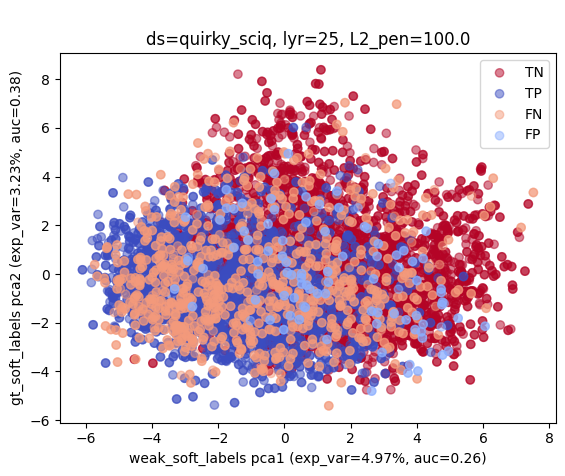

In [144]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

layer = 25
h = r.w2s_train.pre_hiddens[:, layer, :]  # type: ignore
# h, mask = erase_labels(h, r.run.weak_soft_labels, label_erasure="leace")
h = h - h.mean(axis=0)
pca = PCA(n_components=100)
pca.fit(h)

l2 = 1e2
args = {"C": 1 / l2, "max_iter": 1000}
x_axis_method, x_axis = "pca1", "weak_soft_labels"
y_axis_method, y_axis = "pca2", "gt_soft_labels"
x_axis_labs = get_labs(r, x_axis)
y_axis_labs = get_labs(r, y_axis)
proj0 = project_onto(h, x_axis_labs, method=x_axis_method, pca=pca, **args)
proj1 = project_onto(h, y_axis_labs, method=y_axis_method, pca=pca, **args)
h_proj = np.stack([proj0, proj1], axis=1)

ova_var = np.square(h).sum()
exp_var1 = np.square(h_proj[:, 0]).sum() / ova_var
exp_var2 = np.square(h_proj[:, 1]).sum() / ova_var
auc1 = roc_auc_score(x_axis_labs, h_proj[:, 0])
auc2 = roc_auc_score(y_axis_labs, h_proj[:, 1])
print(f"PCA Explained variance: {pca.explained_variance_ratio_.sum()}")
c = np.empty(r.w2s_train.n, dtype=float)
c[get_labs(r, "is_tn")] = 0  # True negative
c[get_labs(r, "is_tp")] = 1  # True positive
c[get_labs(r, "is_fn")] = 0.25  # False negative
c[get_labs(r, "is_fp")] = 0.75  # False positive
for color, name in zip([0, 1, 0.25, 0.75], ["TN", "TP", "FN", "FP"]):
    m = c == color
    plt.scatter(h_proj[:, 0][m], h_proj[:, 1][m], c=c[m], cmap="coolwarm_r", alpha=0.5, vmin=0, vmax=1, label=name)

plt.xlabel(f"{x_axis} {x_axis_method} (exp_var={100*exp_var1:.2f}%, auc={auc1:.2f})")
plt.ylabel(f"{y_axis} {y_axis_method} (exp_var={100*exp_var2:.2f}%, auc={auc2:.2f})")

ds_name = r.cfg["ds_name"]
plt.title(f"\nds={ds_name}, lyr={layer}, L2_pen={l2}")

plt.legend()
plt.show()


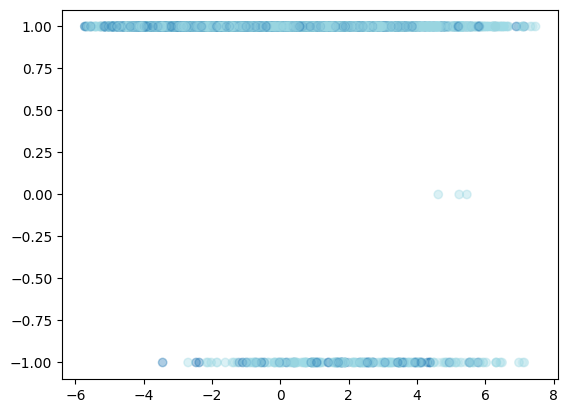

In [117]:
from hdbscan import HDBSCAN

pca_h = pca.transform(h)[:, :20]
pca_h, _ = erase_labels(pca_h, r.run.weak_soft_labels, label_erasure="leace")

clusterer = HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)
clusterer.fit(pca_h)
tree = clusterer.condensed_tree_
plt.figure()
plt.scatter(pca_h[:, 0], clusterer.labels_, c=get_labs(r, "is_correct"), cmap="tab20", alpha=0.2)
plt.show()

(array([302.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 118.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

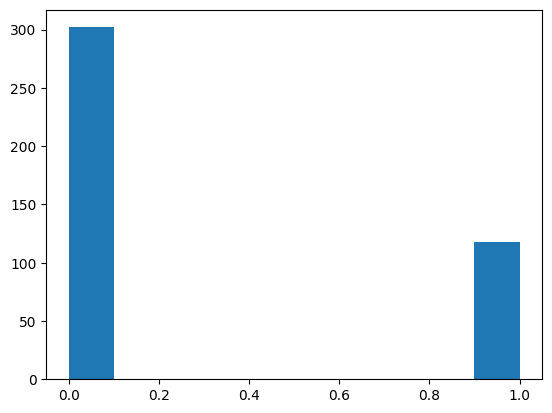

In [128]:
from collections import Counter
plt.hist(r.w2s_train.gt_soft_labels[clusterer.labels_ == -1], density=False)

<Axes: ylabel='$\\lambda$ value'>

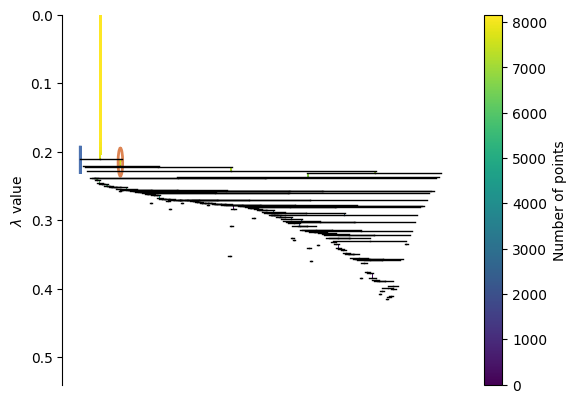

In [122]:
import seaborn as sns
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 8))

(array([300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 118.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

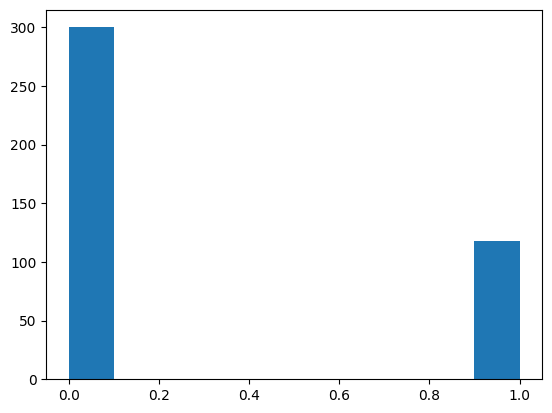

In [143]:
# distance = 1/lambd
clusters = clusterer.single_linkage_tree_.get_clusters(1/0.21, min_cluster_size=100)
plt.hist(r.w2s_train.gt_soft_labels[clusters == -1], density=False)

In [99]:
# TODO: do batch averaging or something to eliminate unwanted variance
# f(x; theta, b) = x @ theta
# grad |f - y| = sign(y - f) * x
# grad f = x
# kernel grad = x_test @ sign(y - f) * x_train

(8640,)

In [203]:
n_test = 1000
test_idxs = np.random.choice(r.run.n, n_test, replace=False)
layer = 20
h = r.run.midtrain_hiddens[:, layer, :]
test_h = h[test_idxs]
batch_size, n_batches = 32, 1000
batches = np.random.choice(len(h), n_batches * batch_size, replace=True)

train_grads = (2 * r.run.weak_soft_labels[:, None] - 1) * h
batch_grads = train_grads[batches].reshape(n_batches, batch_size, -1).mean(axis=1)
batch_kernel_grads = batch_grads @ test_h.T

In [95]:
from transformers import AutoConfig
import os
import json
import torch

def find_paths(root_dir, target_file):
    """ Walk through the directory to find specific files."""
    paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename == target_file:
                paths.append(os.path.join(dirpath, filename))
    return paths

def load_json_config(path_to_file):
    """ Load a JSON file """
    with open(path_to_file, 'r') as file:
        return json.load(file)

root_directory = "../results/"
target_filename = "post_train_hiddens.pt"
config_filename = "config.json"

# Find all paths to the target file
paths_to_target = find_paths(root_directory, target_filename)

# Process found paths
for target_path in paths_to_target:
    # Directory containing the target file
    parent_directory = os.path.dirname(target_path)
    config_path = os.path.join(parent_directory, config_filename)
    
    config = load_json_config(config_path)

    # Assuming you want to do something with the pre_train_hiddens.pt file
    # Load .pt file using torch
    hiddens = torch.load(target_path)
    print(f"Loaded hiddens data from {target_path}")
    
    model = config["model_cfg_name"] or config["model_size"]
    model_config = AutoConfig.from_pretrained(model)
    n_layers = model_config.num_hidden_layers + 1
    print(f"{model} has {n_layers} layers")
    if hiddens.shape[1] == n_layers:
        print(f"Assuming hiddens are already split into {n_layers} layers")
        continue
    
    new_hiddens = hiddens.split(n_layers, dim=1)
    assert len(new_hiddens) == hiddens.shape[1] // n_layers
    assert new_hiddens[0].shape == new_hiddens[-1].shape
    new_hiddens = torch.cat(new_hiddens, dim=0)
    print(f"Concatenated hiddens into shape {new_hiddens.shape}")
    torch.save(new_hiddens, target_path)

Loaded hiddens data from ../results/quirky-pretrained/some_empty_support/bs=32-dd=sqrt-dl=1-dn=quir_sciq-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob/post_train_hiddens.pt
Loaded hiddens data from ../results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_addi-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob/post_train_hiddens.pt
Loaded hiddens data from ../results/quirky-pretrained/bs=32-dd=sqrt-dl=1-dn=quir_sent-e=2-ee=25-lp=0-lbmae=1-l=kl-l=1e-06-lf=1.0-ls=cosi_anne-mc=1024-mcn=None-ms=Mistral-7B-v0.1-nid=0-ntd=1000-ntd=10000-o=adam-stl=1-s=0-sg=0-sh=1-ttft=0-twd=0-wlp=weak_labe-wms=Bob/post_train_hiddens.pt
Loaded hiddens data from ../results/logconf/cosmos_qa/bs=32-dd=sqrt-dl=1-dn=cosm_qa-e=2-ee=25-lp=0-lbmae=1-l=logconf-l=1